Compute the average gas use (similar to the energy use). The difference is that this assumes pulse data instead of fixed-frequency readings. That means that the time between readings varies and that the reported value should correspond to the difference (additional energy used) since the last reading. Theoretically, this should mean that no reading can be lost and that there should be no "missing" values. As this might not be true in practice, times for which no estimate should be computed can be marked by explicitly adding NaNs to the input time series.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '../src')

import pickle
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.ticker as plticker

from datetime import timedelta
from pathlib import Path
from multiprocessing import Pool
from functools import partial

from IdealDataInterface import IdealDataInterface

from config import TIME_FORMAT
from config import SENSOR_DATA_FOLDER, CACHE_FOLDER, CPU_HIGH_MEMMORY, CPU_LOW_MEMMORY
from config import EVALUATION_PERIOD, FFILL_LIMIT, N_SAMPLES, SAMPLING_WINDOW, BASELINE_NR_DAYS
from config import GAS_GAP_THRESHOLD
from utils import treatment_control, load_cached_data
from sampling import data_to_sample_array, sample_energy, compute_sample_sizes, compute_estimate

In [3]:
# Run plotting styles
%run -i '../src/sns_styles.py'

cmap = sns.color_palette()

In [4]:
df_group = treatment_control()

df_group.tail()

,homeid,group,start_date,end_date
263,331,treatment,2018-05-15,2018-06-30
264,332,treatment,2018-05-15,2018-06-30
265,334,control,2018-05-15,2018-06-30
266,335,treatment,2018-05-15,2018-06-30
267,333,control,2018-05-15,2018-06-30


In [5]:
homeid_control = df_group.loc[df_group['group'] == 'control','homeid']
homeid_treatment = df_group.loc[df_group['group'] == 'treatment','homeid']
homeid_enhanced = df_group.loc[df_group['group'] == 'enhanced','homeid']

print('Found {} homes in the control group'.format(len(homeid_control)))
print('Found {} homes in the treatment group'.format(len(homeid_treatment)))
print('Found {} homes in the enhanced group'.format(len(homeid_enhanced)))

Found 107 homes in the control group
Found 106 homes in the treatment group
Found 39 homes in the enhanced group


In [6]:
data_interface = IdealDataInterface(SENSOR_DATA_FOLDER)

In [7]:
df = data_interface.view()

In [8]:
df.head()

,homeid,roomid,room_type,category,subtype,sensorid
0,100,1041,bedroom,room,light,4489
1,100,1041,bedroom,room,humidity,4490
2,100,1041,bedroom,room,temperature,4491
3,100,1042,bedroom,room,light,4494
4,100,1042,bedroom,room,humidity,4495


In [9]:
def select_day(ts, day):
    """ Select the pulse readings for a given day. This will add the last value of the previous day
    and the first value of the next day. """
    # Create the indices
    idx = (ts.index.floor('D') == day)
        
    # Add the previous value. We substract a tiny value from the day as this will
    # ensure that we will get the reading from a previous day
    idx[ts.index.get_loc(day-np.timedelta64(100, 'ns'), method='ffill')] = True
    
    # Add the following value. Add one day and a few nanoseconds to make sure the
    # following day is included
    idx[ts.index.get_loc(day+np.timedelta64(86400000000100, 'ns'), method='bfill')] = True
    
    return ts[idx]

In [10]:
def compute_gas_usage_day(ts, gap_threshold, copy=True):
    """ Compute the energy use during a day. If a value explicitly set to NaN is found it will return
    NaN. Pulses that are on the "edge", i.e. cross the boundary of the day, will be included based on
    the fraction of time that falls into the day. That is, it will be assumed that the energy use was
    cosntant during the time and as such can be split between the days.
    
    args:
       ts: The pulse data as time series
       gap_threshold: The maximum number of days allowed between to pulses to be included. Gaps greater
                      or equal will be considered as "bad" and NaN will be returned.
       
    """
    if copy:
        ts = ts.copy()
    
    gas_use = np.nan
    
    # A missing value indicates that we can't trust this period and shouldn't compute
    # the gas use.
    if ts.isna().any():
        return gas_use
    
    # If the day was missing in the original timeseries only two readings will be in ts
    if len(ts) == 2:
        assert ts.index[1] - ts.index[0] > pd.Timedelta(days=1)
        ts.iloc[-1] *= pd.Timedelta(days=1) / (ts.index[1] - ts.index[0])
    else:
        assert isinstance(ts.index, pd.DatetimeIndex)
        assert ts.index[0] < ts.index[1].floor('D')
        assert ts.index[-1] > ts.index[-2].ceil('D')
        assert len(np.unique(ts.index[1:-1].day)) == 1

        # Compute the fraction to be included at the beginning of the day
        ts.iloc[1] *= (ts.index[1] - ts.index[1].floor('D')) / (ts.index[1] - ts.index[0])

        # Compute the fraction to be included at the end of the day
        ts.iloc[-1] *= (ts.index[-2].ceil('D') - ts.index[-2]) / (ts.index[-1] - ts.index[-2])

    
    # Only compute the gas use if the maximum difference between the pulses is small enough
    if any(ts.index.to_series().diff() >= pd.Timedelta(days=gap_threshold)):
        gas_use = np.nan
    else:
        # Ignore the first value as this belongs to the previous day
        gas_use = ts.iloc[1:].sum()
    
    return gas_use

In [11]:
def compute_gas_usage_period(ts, start=None, end=None, gap_threshold=5):
    """ Compute the daily gas use during a given period. If start and/or end are missing, will
    compute for the available period. See compute_gas_usage_day for description of gap_threshold. """
    # Select the days for which the gas usage will be computed
    #days = pd.date_range(start=ts.index.floor('D').min(), end=ts.index.floor('D').max())
    if start is None:
        start = ts.index.min().ceil('D')
    if end is None:
        end = ts.index.max().floor('D') - pd.Timedelta(seconds=1)
        
    days = pd.date_range(start=start, end=end, freq='D')
    
    gas_use = list()
    for day in days:
        try:
            ts_day = select_day(ts, day)
            gas_use.append(compute_gas_usage_day(ts_day, gap_threshold))
        except KeyError:
            # select_day throws a KeyError if the surrounding readings for the day are not found
            # e.g. because the day is not present in the timeseries or its the first or last day.
            gas_use.append(np.nan)
            
    return pd.Series(np.array(gas_use), index=days, name='gas_use')

# Some examples

This can be skipped. It is merely to have a look and get an understanding of how it works.

In [12]:
# Check which sensorids are gas
df[df['subtype'] == 'gas'].tail()

,homeid,roomid,room_type,category,subtype,sensorid
8190,94,990,hall,gas-pulse,gas,3982
8268,96,997,livingroom,gas-pulse,gas,4112
8270,99,1028,outside,gas-pulse,gas,4391
8291,97,1010,hall,gas-pulse,gas,4219
8331,98,1019,hall,gas-pulse,gas,4298


/disk/scratch/nberline/bin/miniconda3/envs/IDEAL-CPU/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


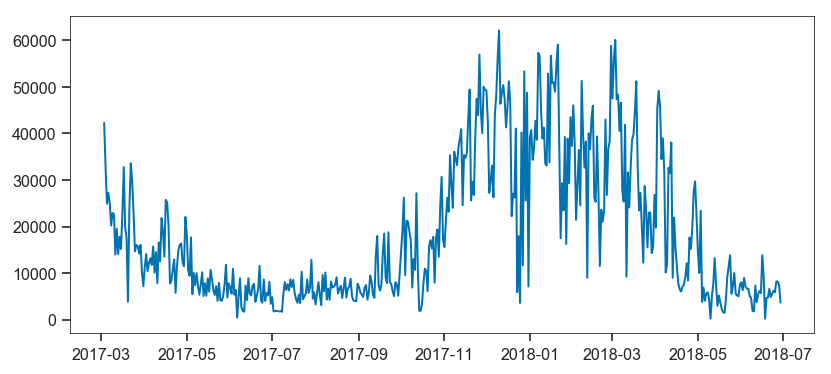

In [13]:
# Pick a random one and compute the gas use
ts = data_interface.get(sensorid=4298)[0]['readings']
gas_use = compute_gas_usage_period(ts, gap_threshold=GAS_GAP_THRESHOLD)
plt.plot(gas_use);

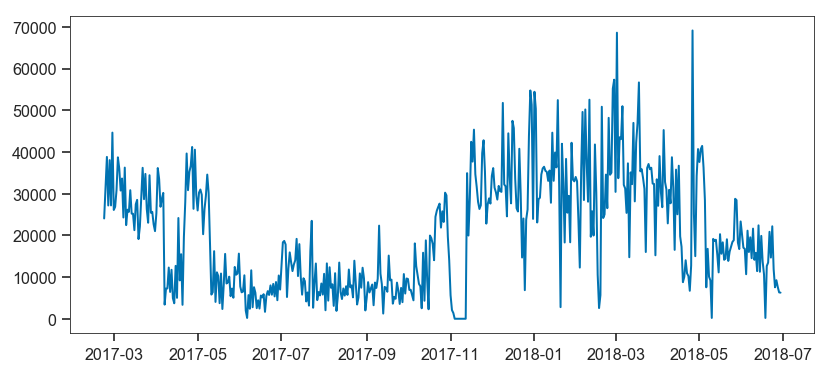

In [14]:
ts = data_interface.get(sensorid=3982)[0]['readings']
gas_use = compute_gas_usage_period(ts, gap_threshold=GAS_GAP_THRESHOLD)
plt.plot(gas_use);

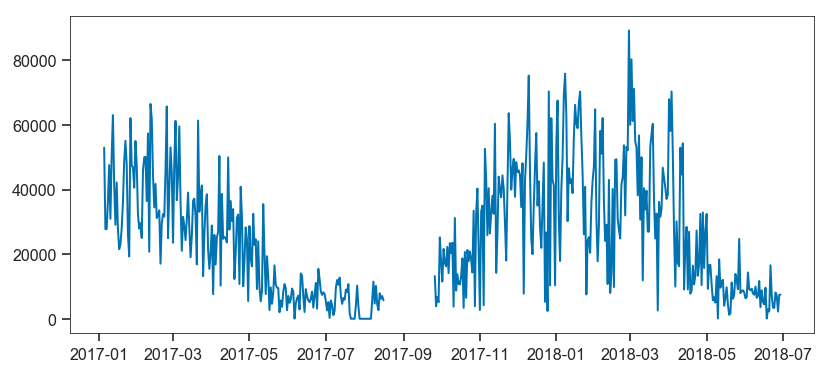

In [15]:
ts = data_interface.get(sensorid=2401)[0]['readings']
gas_use = compute_gas_usage_period(ts, gap_threshold=GAS_GAP_THRESHOLD)
plt.plot(gas_use);

# Compute the gas use for each home in each period

In [16]:
homeids = list(homeid_control) + list(homeid_treatment)

def func(homeid):
    data_interface = IdealDataInterface(SENSOR_DATA_FOLDER)
    df_group = treatment_control()
    
    # Load the data
    ts = data_interface.get(homeid=homeid, subtype='gas')[0]['readings']
    
    # Compute the daily gas use for the whole period
    estimates = compute_gas_usage_period(ts, gap_threshold=GAS_GAP_THRESHOLD)
    
    # Write the estimates to disk
    fpath = Path('../data/rolling_gas_estimates/')
    if not fpath.is_dir():
        fpath.mkdir()
        
    fname = fpath / Path('homeid{}_estimated_rolling_gas_use.csv'.format(homeid))
    estimates.reset_index().rename(columns={'index':'date'})\
             .to_csv(fname, sep='\t', float_format='%.3f', index=False)
    
    # Now the gas use is computed for the whole period. Assemble the bits for the periods of interest.
    # Assemble a DataFrame with the estimates for the periods of interest
    result = dict()
    for period, (start_date, end_date) in EVALUATION_PERIOD.items():
        # Select the pre-computed estimates
        estimates_period = estimates[(estimates.index >= start_date) & 
                                     (estimates.index < (end_date + pd.Timedelta(seconds=1)))]
        
        # Store the result
        result[period] = {'mean':np.nan, 'std':np.nan, 
                          'N':np.sum(np.isfinite(estimates_period)),
                          'period_start':str(start_date)[:10], 'period_end':str(end_date)[:10]}
        if not all(np.isnan(estimates_period)):
            result[period] = {'mean':np.nanmean(estimates_period), 'std':np.nanstd(estimates_period), 
                              'N':np.sum(np.isfinite(estimates_period)),
                              'period_start':str(start_date)[:10], 'period_end':str(end_date)[:10]}
        
    # Add the baseline estimate.
    # Select the respective time range
    end_date = df_group.loc[df_group['homeid'] == homeid,'start_date'].values[0]
    start_date = end_date - np.timedelta64(BASELINE_NR_DAYS-1, 'D')
    estimates_baseline = estimates[(estimates.index >= start_date) & 
                                   (estimates.index <= end_date)]
    
    # Store the result
    result['baseline'] = {'mean':np.nan, 'std':np.nan, 
                          'N':np.sum(np.isfinite(estimates_baseline)),
                          'period_start':str(start_date)[:10], 'period_end':str(end_date)[:10]}
    if not all(np.isnan(estimates_baseline)):
        result['baseline'] = {'mean':np.nanmean(estimates_baseline), 'std':np.nanstd(estimates_baseline), 
                          'N':np.sum(np.isfinite(estimates_baseline)),
                          'period_start':str(start_date)[:10], 'period_end':str(end_date)[:10]}
        
    # Convert to DataFrame
    result = pd.DataFrame.from_dict(result, orient='index').reset_index().rename(columns={'index':'period'})
    result['homeid'] = homeid
    
    result = result[['homeid', 'period', 'period_start', 'period_end', 'mean', 'std', 'N']]

    return result

with Pool(processes=CPU_LOW_MEMMORY) as pool:
    estimates = pool.map(func, homeids)

In [17]:
df_result = pd.concat(estimates)

# Note that the start and end periods are inclusive
df_result.head(6)

,homeid,period,period_start,period_end,mean,std,N
0,59,P1_1,2017-07-03,2017-09-10,8526.417377,4667.838097,70
1,59,P1_2,2017-09-11,2017-11-19,16111.822669,14207.169360,70
2,59,P2_1,2017-11-23,2018-01-31,37139.260252,20283.311450,64
3,59,P2_2,2018-02-01,2018-04-11,NaN,NaN,0
4,59,P3,2018-04-20,2018-06-28,NaN,NaN,0
5,59,baseline,2017-02-03,2017-03-16,31699.641193,16130.899836,42


In [18]:
fname = '../data/estimated_gas_averages.csv'

df_result.to_csv(fname, sep='\t', float_format='%.3f', index=False)